# Decision Tree

## Load Packages and Prep Data

In [22]:
# import needed packages
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
tree.DecisionTreeClassifier?

Init signature:
tree.DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum de

In [3]:
# load data
train_data = pd.read_csv('data/train_data_fe.csv')
test_data = pd.read_csv('data/test_data_fe.csv')
print(train_data.shape)
print(test_data.shape)

(62889, 47)
(15723, 47)


In [4]:
# drop unneeded columns
train_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)
test_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)

In [5]:
# prep data
y_train = train_data['stone_soil_enc']
X_train = train_data.drop(['stone_soil_enc'], axis=1)
y_test = test_data['stone_soil_enc']
X_test = test_data.drop(['stone_soil_enc'], axis=1)

In [6]:
# define a function for scoring
def pred_metrics(real, pred) -> None:
    print("Accuracy:\t{}".format(accuracy_score(real, pred)))
    print("Precision:\t{}".format(precision_score(real, pred)))
    print("Recall:\t\t{}".format(recall_score(real, pred)))
    print("F1:\t\t{}".format(f1_score(real, pred)))

## Model 1
- Defaults

In [9]:
# fit decision tree with default hyperparameters
dt_1 = tree.DecisionTreeClassifier()
x = dt_1.fit(X_train, y_train)

In [10]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(dt_1, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.6317 0.617  0.6259 0.6007 0.6294]
0.621


## Model 2
- Reduce overfitting with tree limitations

In [14]:
# fit decision tree with custom hyperparameters
dt_2 = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=7)
x = dt_2.fit(X_train, y_train)

In [15]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(dt_2, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.6858 0.6731 0.6981 0.6754 0.6593]
0.6784


## Model 3
- Grid search hyperparameters

In [16]:
# find best parameters by grid search
paras = {"max_depth":[*range(3,16,3)], "min_samples_leaf":[*range(5,16,5)]}
gs = GridSearchCV(tree.DecisionTreeClassifier(), paras, cv=10, scoring='f1')
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_.round(decimals=4))

dt_3 = gs.best_estimator_

{'max_depth': 9, 'min_samples_leaf': 5}
0.6965


## Test

In [17]:
# test
y_pred = dt_3.predict(X_test)
pred_metrics(y_test, y_pred)

Accuracy:	0.953762004706481
Precision:	0.7215346534653465
Recall:		0.5373271889400921
F1:		0.6159535129424193


<AxesSubplot:>

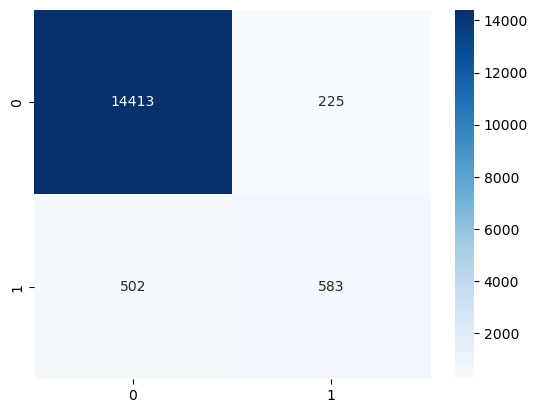

In [23]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'g', cmap = 'Blues')

## Visualize Tree
- Take a look at the decision tree

In [18]:
text_representation = tree.export_text(dt_3)
print(text_representation)

|--- feature_25 <= 0.54
|   |--- feature_30 <= 0.18
|   |   |--- feature_25 <= 0.49
|   |   |   |--- feature_36 <= 0.41
|   |   |   |   |--- feature_41 <= 0.03
|   |   |   |   |   |--- feature_25 <= 0.43
|   |   |   |   |   |   |--- feature_23 <= 0.12
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_23 >  0.12
|   |   |   |   |   |   |   |--- feature_42 <= 0.33
|   |   |   |   |   |   |   |   |--- feature_37 <= 0.42
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_37 >  0.42
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_42 >  0.33
|   |   |   |   |   |   |   |   |--- feature_36 <= 0.01
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_36 >  0.01
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_25 >  0.43
|   |   |   |   |   |   |--- feature_30 <= 0.09
|   |   |   |   |   |   |   |--- featu

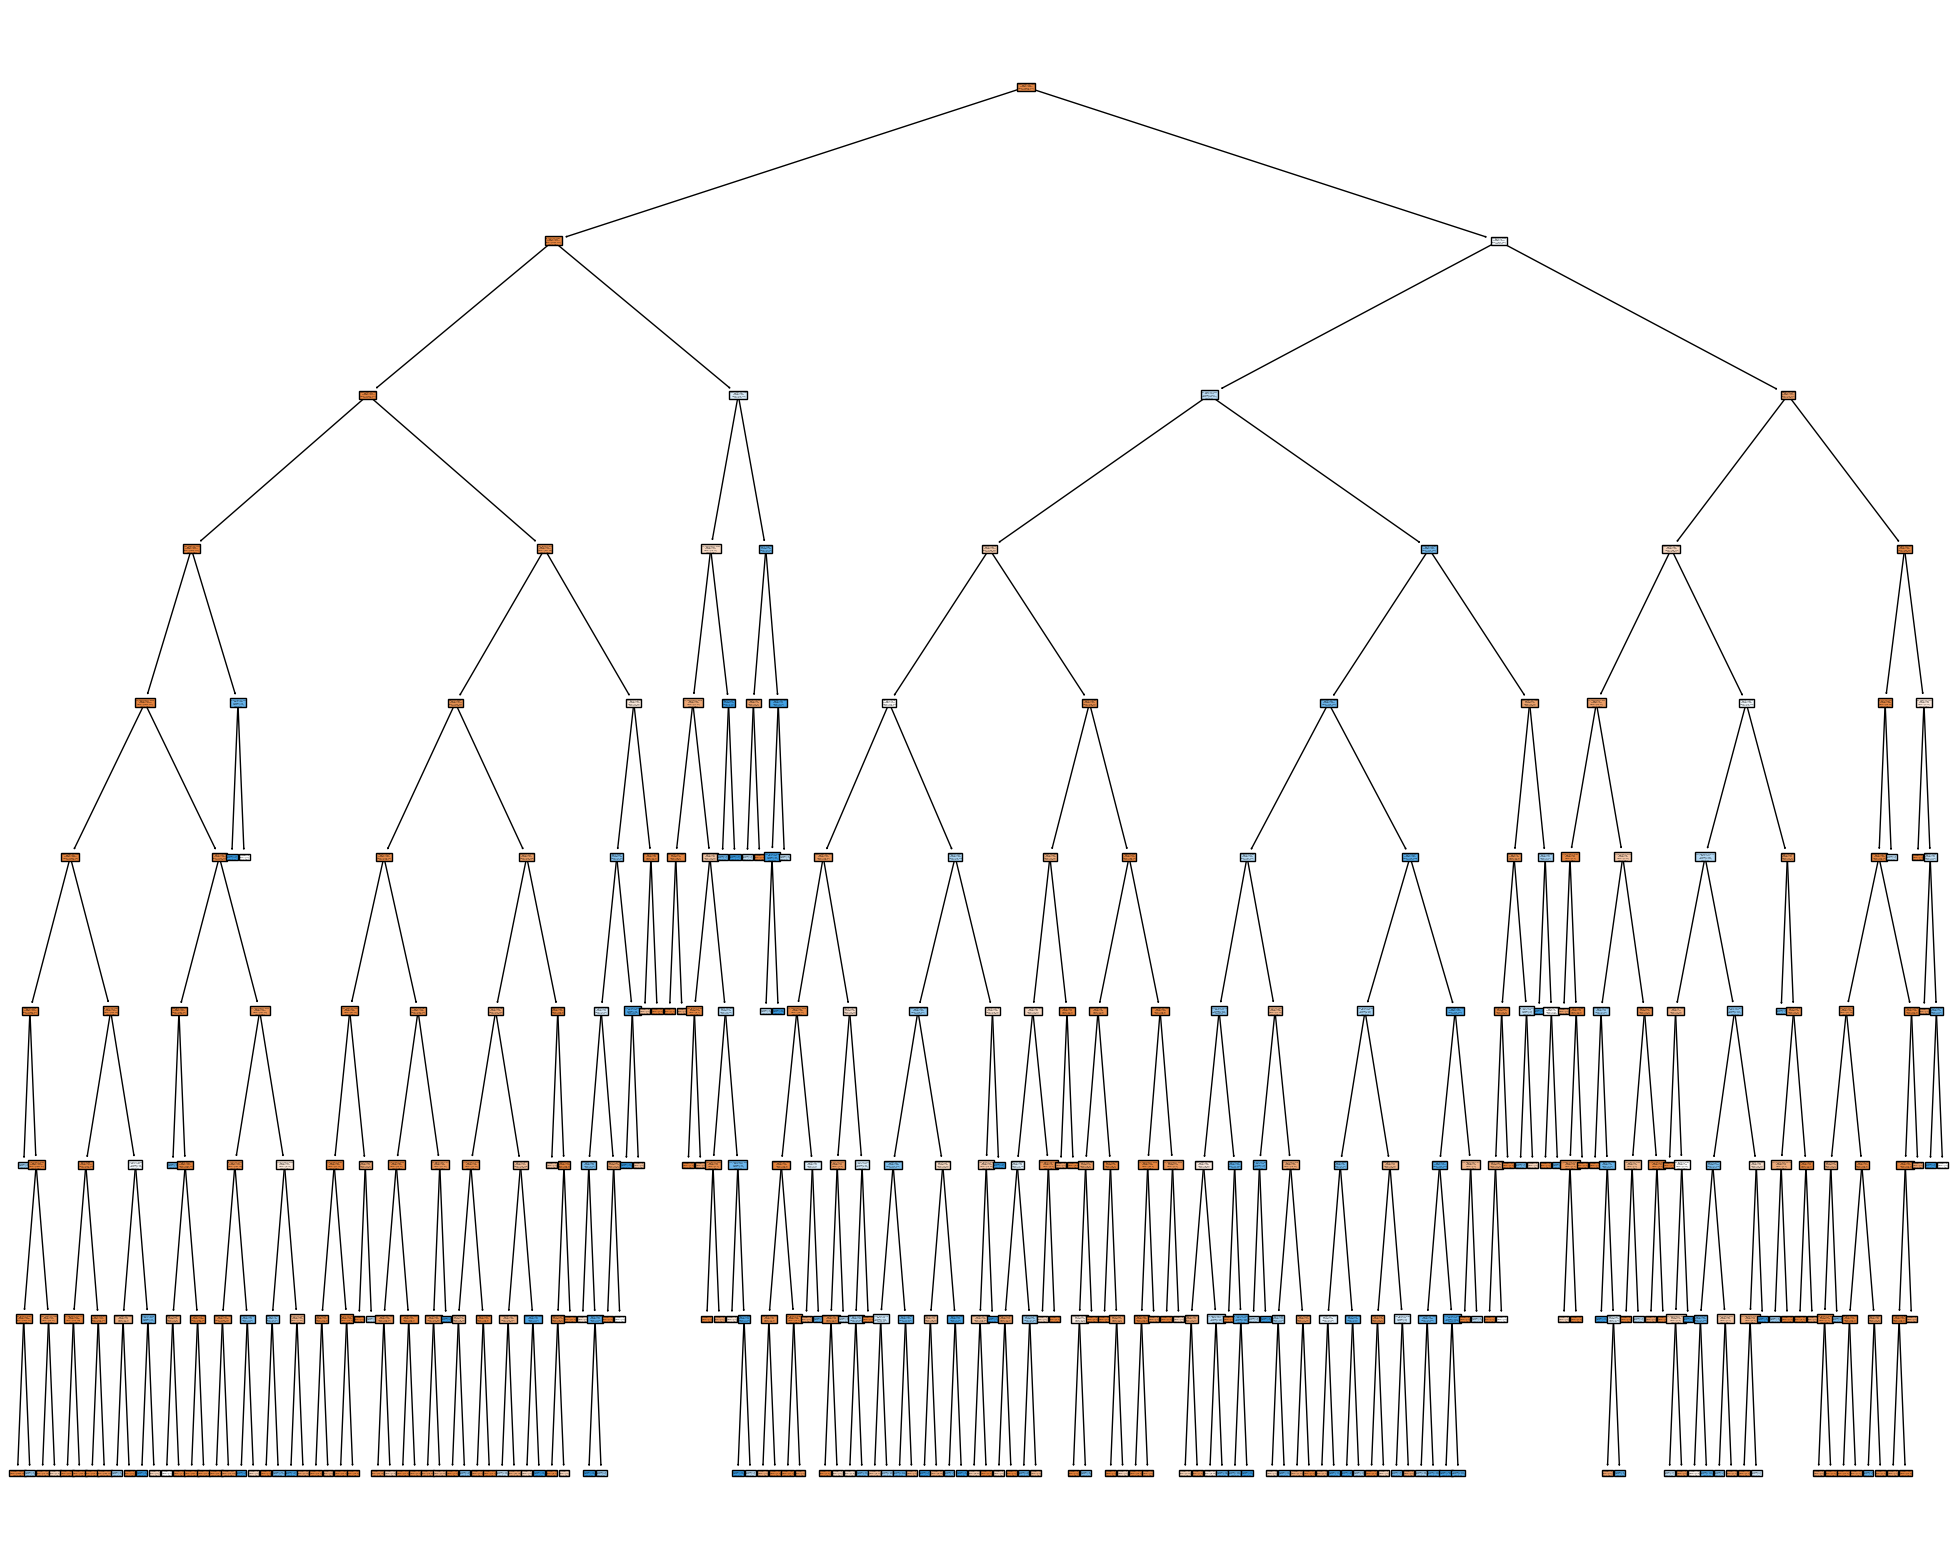

In [21]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_3, 
                   feature_names=X_train.columns,  
                   class_names=['stone', 'soil'], # need to confirm this ordering
                   filled=True)